In [2]:
from src import disrnn
from src import gru
from src import switch_utils
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk


In [88]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'
model_dir = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

# choose mouse, beta and run time
model_name = 'rnn'
train_prop = 0.7
param = 2
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
train_dt = "2025-04-18_00-24"
split_dt = "2025-04-17_10-28"
batch_size = 64

model_shape = {'dis_latent_size': 5,
                'tiny_latent_size': param,
                'update_mlp_shape': (5,5,5),
                'choice_mlp_shape': (2,2),
                'obs_size': 2,
                'target_size': 2}

param_dict = {'disrnn': f'{param:.0e}', 'rnn': f'{param}'}
params_file = os.path.join(model_dir, f"params_{model_name}_{param_dict[model_name]}_{cv}_{train_dt}.json")
loss_file = os.path.join(model_dir, f"loss_{model_name}_{param_dict[model_name]}_{cv}_{train_dt}.csv")

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

params, losses = switch_utils.model_loader(params_file=params_file, loss_file=loss_file)

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)

def model_factory(model_name, model_shape):
    if model_name == 'disrnn':
        def make_network_eval():
            return disrnn.HkDisRNN(update_mlp_shape=model_shape['update_mlp_shape'],
                                    choice_mlp_shape=model_shape['choice_mlp_shape'],
                                    latent_size=model_shape['dis_latent_size'],
                                    obs_size=model_shape['obs_size'], 
                                    target_size=model_shape['target_size'],
                                    eval_mode=True)
    else: 
        def make_network_eval():
            return gru.HkGRU(hidden_size=model_shape['tiny_latent_size'], 
                             target_size=model_shape['target_size'])
    return make_network_eval

make_network_eval = model_factory(model_name, model_shape)


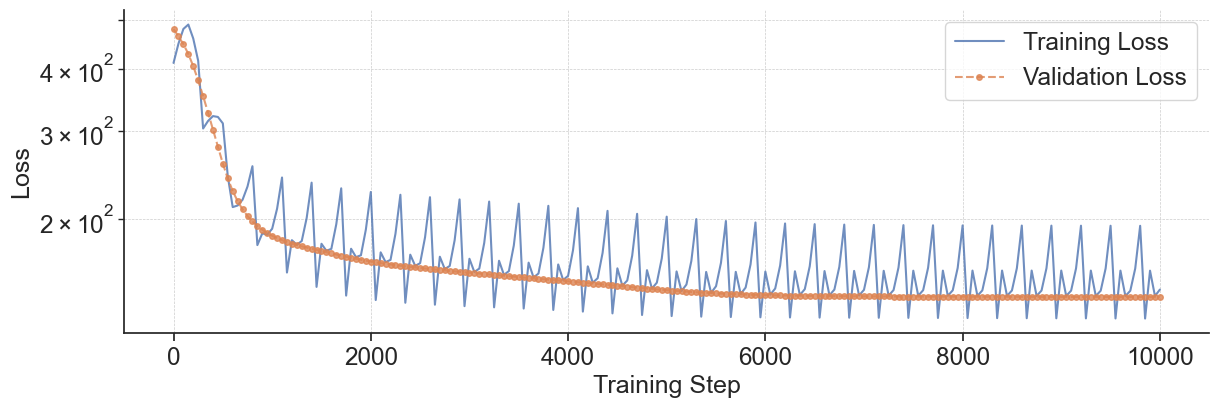

In [89]:
plt.figure(figsize=(14, 4.2))
sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 
plt.semilogy(losses.index*50, losses['training_loss'], label='Training Loss', alpha=0.8, color=sns.color_palette()[0])
plt.semilogy(losses.index*50, losses['validation_loss'], label='Validation Loss', linestyle='--', marker='o', markersize=4, alpha=0.8, color=sns.color_palette()[1])
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [90]:
def unroll_network(xs):
  core = make_network_eval()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk = hk.transform(unroll_network)
step_hk = jax.jit(step_hk)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output = step_hk(params, random_key, ds_va._xs)[:,:,:2]

### Discrete Dynamical System

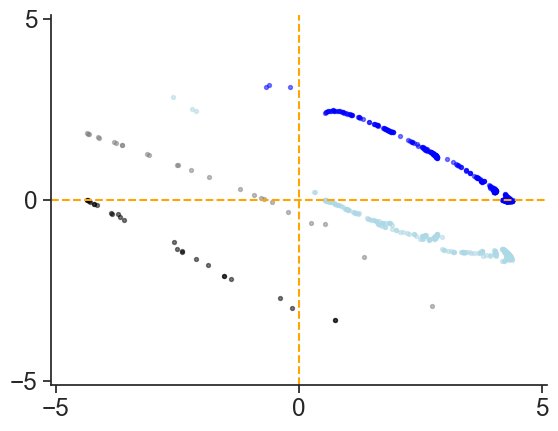

In [91]:
logits = jax.nn.log_softmax(output, axis=2)[:,:,0] - jax.nn.log_softmax(output, axis=2)[:,:,1]
logits_change = jnp.diff(logits, axis=0)


sess = (150)
logits=logits[:-1]
logits_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits)
logits_change_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits_change)

ac_re_arr = ds_va._xs[:,:,0] + 2* ds_va._xs[:,:,1]
ac_re_mask = np.ma.masked_where(ds_va._xs[:,:,0]==-1, ac_re_arr)

x=logits_ma[:,sess]
y=logits_change_ma[:,sess]
labels = ['A=0, R=0', 'A=1, R=0', 'A=0, R=1', 'A=1, R=1']
colors = ['lightblue', 'gray', 'blue', 'black']
for i in range(4):
    plt.scatter(x=(x[np.argwhere(ac_re_mask[1:,sess]==i)].flatten()), 
                y=y[np.argwhere(ac_re_mask[1:,sess]==i)].flatten(), 
                label=labels[i],
                s=8,
                color=colors[i],
                alpha=0.5)
plt.axhline(0, color='orange', linestyle='--')
plt.axvline(0, color='orange', linestyle='--')
plt.xlim(-5.1,5.1)
plt.ylim(-5.1,5.1)
# plt.legend()
sns.despine()
plt.xticks([-5,0,5])
plt.yticks([-5,0,5])
plt.show()